In [5]:
import spotpy
from mogestpy.quantity.Hydrological import SMAP
import pandas as pd

df = pd.read_excel(r'D:\Dados\smap_jundiai.xlsx')
display(df)

,ETP,P,Qobs,Qplan
0,5.266667,0.000000,1.69,-0.323000
1,5.266667,0.000000,0.06,-0.319765
2,5.266667,1.100000,0.41,-0.316562
3,5.266667,0.000000,0.06,-0.313391
4,5.266667,0.000000,1.94,-0.310251
...,...,...,...,...
2118,3.233333,0.000000,0.11,0.028231
2119,3.233333,0.283333,0.09,0.025673
2120,3.233333,0.003333,0.02,0.024410
2121,3.233333,0.496667,0.01,0.023720


In [7]:
help(SMAP)

IndexError: list index out of range

Calibrador

In [3]:
bacia = SMAP.SMAP.Basin(
    Str=100,
    k2t=0.848790939326689,
    Crec=1.00998050978914,
    Ai=2.44891091946412,
    Capc=50,
    kkt=68.85081378162,
    TUin=5/100,
    EBin=0,
    AD=109.08
)
ponto = SMAP.SMAP.Point(df['P'], df['ETP'])
modelo = SMAP.SMAP(ponto, bacia)
modelo.RunModel()

kge = spotpy.objectivefunctions.kge(df['Qobs'], modelo.Q)

print(kge)

0.6638708466297513


In [4]:
df

,ETP,P,Qobs,Qplan
0,5.266667,0.000000,1.69,-0.323000
1,5.266667,0.000000,0.06,-0.319765
2,5.266667,1.100000,0.41,-0.316562
3,5.266667,0.000000,0.06,-0.313391
4,5.266667,0.000000,1.94,-0.310251
...,...,...,...,...
2118,3.233333,0.000000,0.11,0.028231
2119,3.233333,0.283333,0.09,0.025673
2120,3.233333,0.003333,0.02,0.024410
2121,3.233333,0.496667,0.01,0.023720


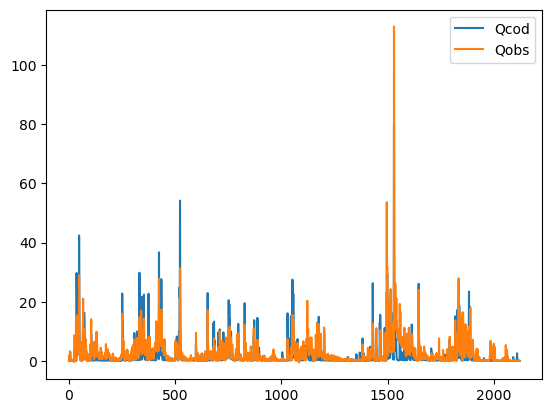

In [5]:
df['Qcod'] = modelo.Q

df.filter(items=['Qcod', 'Qobs']).plot()


In [9]:
import spotpy
import scipy.optimize
from scipy.optimize import differential_evolution
scipy.optimize.options={'disp': True}

precipitation = df.P.to_list()
evapotranspiration = df.ETP.to_list()
observed_discharge = df.Qobs

bounds = [[100.0, 2000.0],  # Str              
              [0.0, 20],    # Crec
              [0.0, 1.0],   # TUin
              [0.0, 20],    # EBin
              [30, 50],     # Capc
              [30, 180],    # kkt
              [0.2, 10],    # k2t
              [2, 5]]       # Ai

def objective(p):
    Str, Crec, TUin, EBin, Capc, kkt, k2t, Ai = p

    bacia = SMAP.SMAP.Basin(
        Str=Str,
        k2t=k2t,
        Crec=Crec,
        Ai=Ai,
        Capc=Capc,
        kkt=kkt,
        TUin=TUin,
        EBin=EBin,
        AD=109.08
        )
    
    ponto = SMAP.SMAP.Point(precipitation, evapotranspiration)
    modelo = SMAP.SMAP(ponto, bacia)
    modelo.RunModel()

    return -spotpy.objectivefunctions.kge(observed_discharge, modelo.Q)


result = differential_evolution(objective, bounds, maxiter=1000)

In [10]:
for i in result['x']:
    print(i)

100.0
18.674180930243484
0.0
3.390072996516954
30.0
30.0
0.4297617097796197
2.0


In [11]:
import spotpy
import scipy.optimize
from scipy.optimize import minimize

precipitation = df.P.to_list()
evapotranspiration = df.ETP.to_list()
observed_discharge = df.Qobs

bounds = [[100.0, 2000.0],  # Str              
              [0.0, 20],    # Crec
              [0.0, 1.0],   # TUin
              [0.0, 20],    # EBin
              [30, 50],     # Capc
              [30, 180],    # kkt
              [0.2, 10],    # k2t
              [2, 5]]       # Ai

def objective(p):
    Str, Crec, TUin, EBin, Capc, kkt, k2t, Ai = p

    bacia = SMAP.SMAP.Basin(
        Str=Str,
        k2t=k2t,
        Crec=Crec,
        Ai=Ai,
        Capc=Capc,
        kkt=kkt,
        TUin=TUin,
        EBin=EBin,
        AD=109.08
        )
    
    ponto = SMAP.SMAP.Point(precipitation, evapotranspiration)
    modelo = SMAP.SMAP(ponto, bacia)
    modelo.RunModel()

    return -spotpy.objectivefunctions.kge(observed_discharge, modelo.Q)


result = minimize(objective, x0=[100, 0, 0, 0, 39, 39, .2, 2], bounds=bounds)

for i, j in zip(result['x'], ['Str', 'Crec', 'TUin', 'EBin', 'Capc', 'kkt', 'k2t', 'Ai']):
    print(f'{j} = {i},')

Str = 100.0,
Crec = 18.67356169526103,
TUin = 0.0,
EBin = 3.390137404859508,
Capc = 30.0,
kkt = 30.0,
k2t = 0.42976573106710725,
Ai = 2.0,


In [13]:
import spotpy
from spotpy.examples.spot_setup_hymod_python import spot_setup

spot_setup = spot_setup()